# Perceptrón

En esta libreta se implementa un clasificador binario con el algoritmo del perceptrón.

### Bibliotecas externas

Se hace uso de [Gadfly](http://gadflyjl.org/) para graficar los datos y de [RDatasets](https://github.com/johnmyleswhite/RDatasets.jl) para importar el conjunto de datos Iris, el cuál se usará para trabajar con el perceptrón.

In [1]:
using Gadfly
using RDatasets

### Los datos de entrenamiento

El algoritmo del perceptrón, en su forma más simple, requiere trabajar sobre datos *linealmente separables* para poder terminal su entrenamiento.

Podemos graficar los datos de entrenamiento para verificar visualmente que son linealmente separables.

En la gráfica de abajo se observa que las **setosas** son linealmente separables del resto de las clases.

In [2]:
iris = dataset("datasets", "iris");

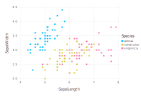

In [3]:
plot(iris, x=:SepalLength, y=:SepalWidth, color=:Species, Geom.point)

Se obtienen las columnas de atributos que nos son de interés y luego se transforman las clases de cadenas de caracteres a los valores numéricos $\{-1,1\}$.

In [4]:
sepalLength = iris[:SepalLength];
sepalWidth = iris[:SepalWidth];
species = iris[:Species];

inputs = [sepalLength sepalWidth];
outcomes = map(name -> name == "setosa" ? +1 : -1, species);

### Predicción

El perceptrón es un clasificador binario lineal, se parametriza con $d+1$ valores reales, donde $d$ es la dimensión de cada dato de entrada.

La hipótesis del perceptrón se define como:

$$h\left(\hat{x}\right)=\mathrm{sign}\left( \hat{w}^{T} \cdot \hat{x} + b  \right)$$

Donde $\hat{x}$ es el vector de entradas, $\hat{w}$ y $b$ son los parámetros del perceptrón, tal que $\|\hat{x}\|=\|\hat{w}\|$.

In [5]:
function predict(weights, bias, input)
    return sign(weights' * input + bias)
end

predict (generic function with 1 method)

### Entrenamiento

Para el entrenamiento, se inicia con todos los parámetros en $0.0$ y se mejoran a partir de los datos mal clasificados, hasta haber conseguido clasificar correctamente todos los datos.

In [6]:
function train(inputs, outcomes)
    measures, dimensions = size(inputs);
    
    weights = zeros(dimensions);
    bias = 0.0
    
    while true
        badResults = 0
        for i in 1:measures
            if predict(weights, bias, inputs[i,:]) != outcomes[i]
                badResults += 1
                weights += outcomes[i] * inputs[i,:]
                bias += outcomes[i]
            end
        end
        badResults == 0 && break
    end
    
    return weights, bias
end

train (generic function with 1 method)

Con el entrenamiento se obtienen los parámetros que separan los datos de entrenamiento.

Estos parámetros, para el caso de $d=2$ pueden ser usados para describir el clasificador como una recta.

In [7]:
weights, bias = train(inputs, outcomes);

slope = -weights[1]/weights[2]
x2cut = -bias/weights[2]
cutsign = x2cut < 0 ? "-" : "+"

println("weights: ", weights)
println("bias: ", bias)
println("classifier line: x2 = $(slope)*x1$(cutsign)$(abs(x2cut))")

weights: [-79.8, 101.4]
bias: 126.0
classifier line: x2 = 0.7869822485207414*x1-1.2426035502958825


Como se observa en la gráfica de abajo, el entrenamiento ha funcionado.

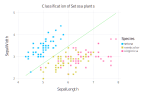

In [8]:
plot(
    layer(
        iris, x=:SepalLength, y=:SepalWidth, color=:Species,
        Geom.point
    ),
    layer(
        length -> -(bias + weights[1]*length)/weights[2],
        minimum(iris[:SepalLength]),
        maximum(iris[:SepalLength]),
        Theme(default_color=colorant"light green")
    ),
    Guide.Title("Classification of Setosa plants")
)